# Experiments on the HELOC dataset

Home Equity Lines Of Credit (HELOC) https://www.kaggle.com/datasets/ajay1735/hmeq-data. 12 input variables, we use 10 continuous features because baseline ROAR does not work on categorical feature types. 1 output variable, toggled 0 and 1 so that 0 is the undesirable outcome (defaulted a loan), 1 is the desirable outcome (loan repaid).

No known distribution shifts in this dataset, so it is used to mimic the daily model updates.



In [3]:
import time
import os, sys, pickle, json, math, time, multiprocessing, warnings, itertools, random, warnings, gc, ast, subprocess
import copy
from collections import defaultdict, Counter, namedtuple
from math import log
from itertools import product, combinations
from random import choice, choices, sample, seed
from datetime import datetime

import gurobipy
from sklearn.metrics.pairwise import euclidean_distances
from importlib import reload
# Basics
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Multi-processing
from joblib import Parallel, delayed
from tqdm import tqdm

# sci-kit learn
import sklearn
import sklearn.datasets as datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from utilexp import *
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from expnns.preprocessor import Preprocessor, min_max_scale


In [4]:
# load dataset
df = pd.read_csv("../datasets/heloc/hmeq.csv", delimiter=',')
continuous_features = ["LOAN", "MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO",
                       "DEBTINC"]
df = df.drop(columns=["REASON", "JOB"])
df = df.dropna()

dfx, dfy = df.drop(columns=['BAD']), pd.DataFrame(df['BAD'])
df = pd.concat([dfx, dfy], axis=1)
display(df)
# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df_mm = min_max_scale(df, continuous_features, min_vals, max_vals)

# get X, y
X, y = df_mm.drop(columns=['BAD']), pd.DataFrame(1 - df_mm['BAD'])

SPLIT = .2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=SPLIT, shuffle=True,
                                                        random_state=0)

ordinal_features = {}
discrete_features = {}
columns = list(df_mm.columns)
feat_var_map = {}
for i in range(len(X.columns)):
    feat_var_map[i] = [i]

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,BAD
5,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1
7,1800,28502.0,43034.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1
19,2300,102370.0,120953.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,0
25,2400,34863.0,47471.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1
26,2400,98449.0,117195.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,0
...,...,...,...,...,...,...,...,...,...,...,...
5955,88900,57264.0,90185.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0
5956,89000,54576.0,92937.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0
5957,89200,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0
5958,89800,50370.0,91861.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0


In [5]:
X1, X2 = X[:1757], X[1757:]
y1, y2 = y[:1757], y[1757:]
SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                        random_state=0)

# Observe model shifts


In [6]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 16)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='f1_macro')
#nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
#search = nns.fit(X, y)
#print(search.best_params_)


In [7]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=5, learning_rate_init=0.005, batch_size=16,
                    max_iter=6000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, X, y, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=5, learning_rate_init=0.005, batch_size=16,
                    max_iter=6000, random_state=0)

clf.fit(X1_train, y1_train)
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X.values)
print('\n', classification_report(y, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.93 test_accuracy with a std of 0.01
0.84 test_precision_macro with a std of 0.08
0.66 test_recall_macro with a std of 0.05
0.71 test_f1_macro with a std of 0.06

                  precision    recall  f1-score   support

 bad credit (0)      0.750     0.176     0.286        34
good credit (1)      0.919     0.994     0.955       318

       accuracy                          0.915       352
      macro avg      0.834     0.585     0.620       352
   weighted avg      0.902     0.915     0.890       352


                  precision    recall  f1-score   support

 bad credit (0)      0.845     0.230     0.361       309
good credit (1)      0.931     0.996     0.962      3206

       accuracy                          0.929      3515
      macro avg      0.888     0.613     0.662      3515
   weighted avg      0.923     0.929     0.909      3515



In [8]:
from joblib import dump, load

#dump(clf, 'heloc.joblib')


['heloc.joblib']

## Test delta

- delta value related to hidden layer size?
    - NO
- typical delta values when continuous training?
    - YES. For a dataset, can find typical values, corresponding to different incremental training gaps


In [9]:
from utilexp import *

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


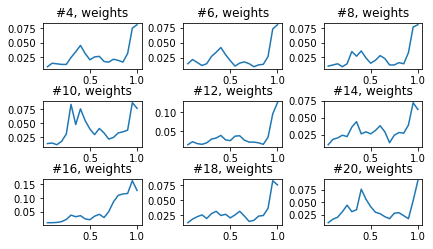

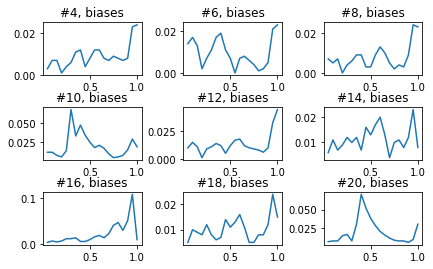

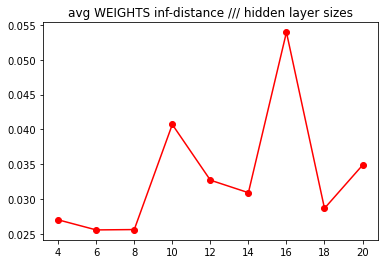

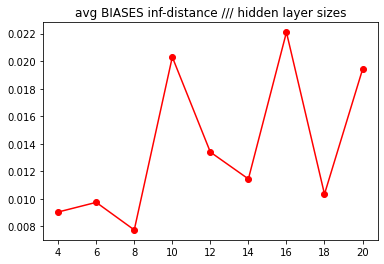

In [10]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is 0.05

train_gap = 0.05
h_hidden_size = np.arange(4, 21, 2)
lr = 0.01
batch_size = 32
max_iter = 8000
avg_w_dists_wrt_sizes, avg_b_dists_wrt_sizes = plot_incremental_training_weight_bias_changes(train_gap, h_hidden_size,
                                                                                             lr, batch_size, max_iter,
                                                                                             X1, y1, X2, y2,
                                                                                             False)


inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.02, 
WEIGHTS or BIASES inf-distance /// % of D2 used


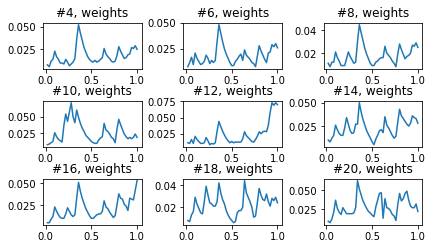

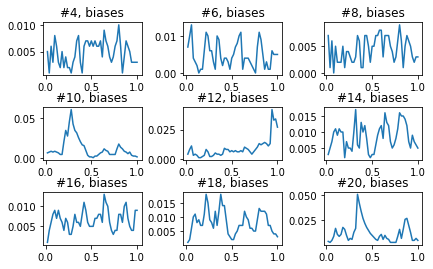

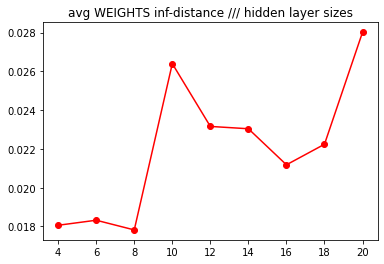

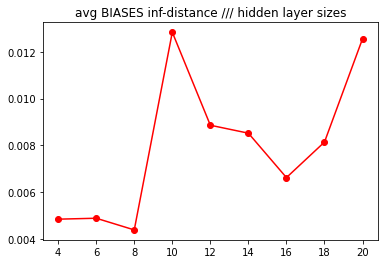

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


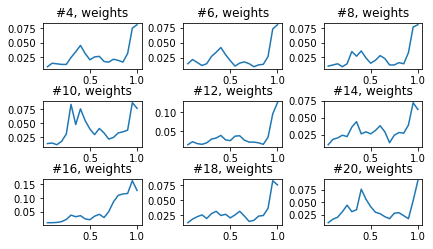

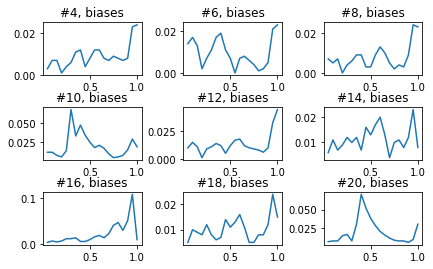

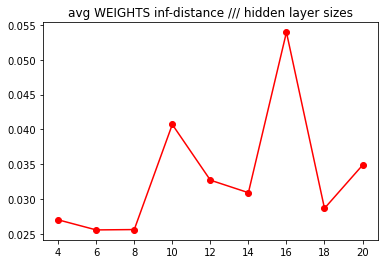

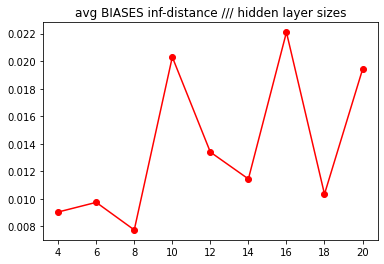

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.1, 
WEIGHTS or BIASES inf-distance /// % of D2 used


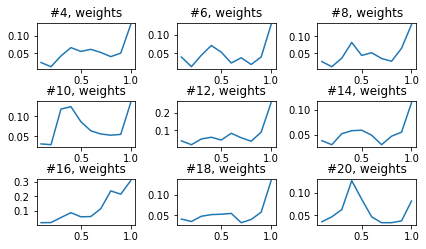

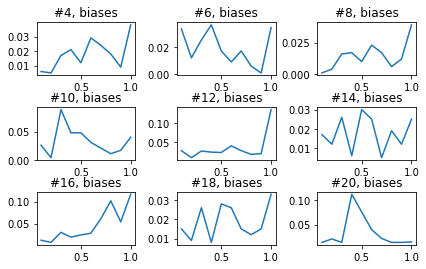

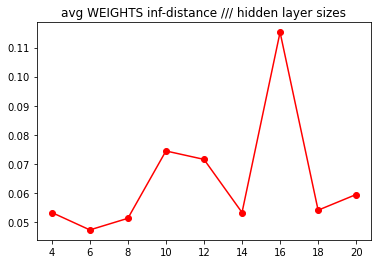

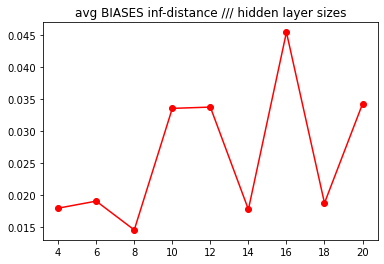

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.2, 
WEIGHTS or BIASES inf-distance /// % of D2 used


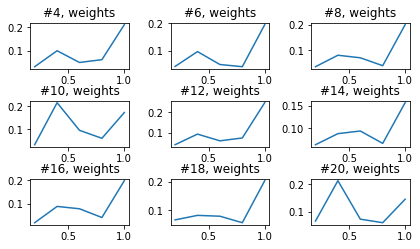

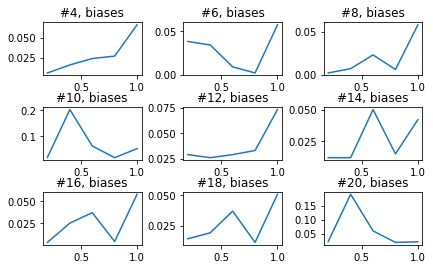

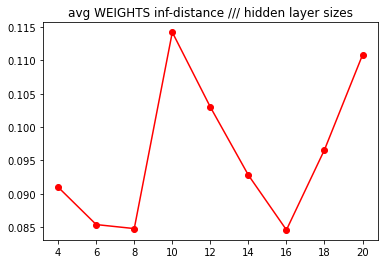

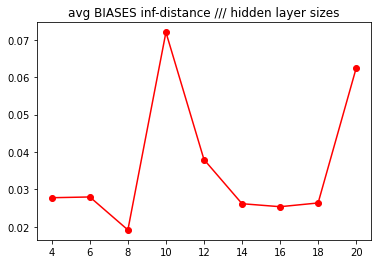

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.25, 
WEIGHTS or BIASES inf-distance /// % of D2 used


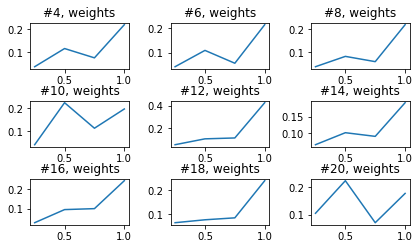

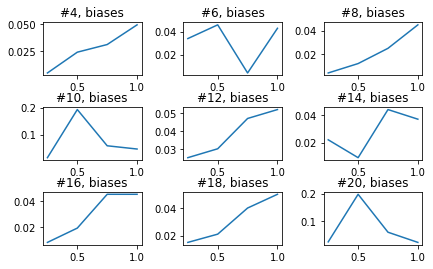

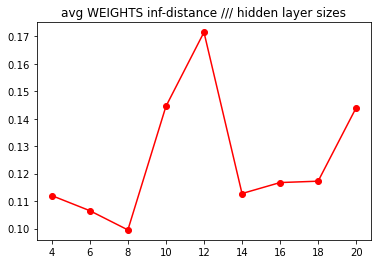

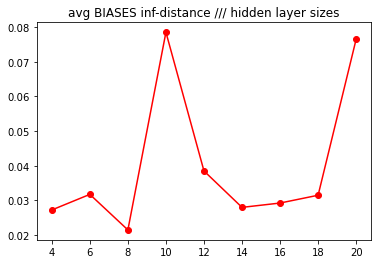

In [11]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is [0.02, 0.05, 0.10, 0.20]

train_gaps = [0.02, 0.05, 0.10, 0.20, 0.25]
h_hidden_size = np.arange(4, 21, 2)
lr = 0.01
batch_size = 32
max_iter = 8000

avg_w_dists_wrt_gaps = []
avg_b_dists_wrt_gaps = []
for gap in train_gaps:
    thisw, thisb = plot_incremental_training_weight_bias_changes(gap, h_hidden_size,
                                                                 lr, batch_size, max_iter,
                                                                 X1, y1, X2, y2)
    avg_w_dists_wrt_gaps.append(thisw)
    avg_b_dists_wrt_gaps.append(thisb)


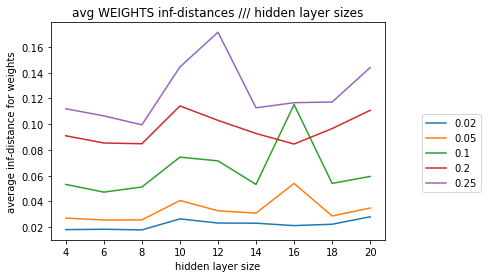

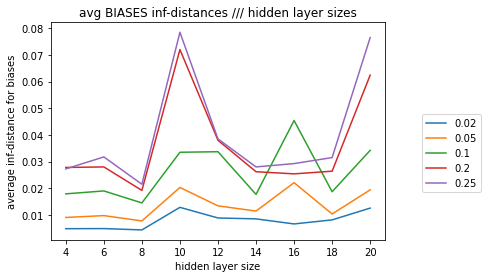

In [12]:
plt.figure(5)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for weights")
for i, item in enumerate(avg_w_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg WEIGHTS inf-distances /// hidden layer sizes')

plt.figure(6)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for biases")
for i, item in enumerate(avg_b_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg BIASES inf-distances /// hidden layer sizes')
plt.show()


# Compute Counterfactuals

In [6]:
from joblib import dump, load

clf = load("heloc.joblib")

gurobipy.setParam("FeasibilityTol", 1e-09)
gurobipy.setParam("OptimalityTol", 1e-09)
gurobipy.setParam("IntFeasTol", 1e-05)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


In [7]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map)
print(util_exp.delta_max)
print(util_exp.delta_min)


0.2089585241092075
0.03562772635529099


In [20]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_custom_delta(delta=0.04, eps=3)


50it [00:00, 137.96it/s]

found: 1.0
average normalised L1: 0.02226647217416159
average normalised L0: 0.15199999999999997
average lof score: 0.12
counterfactual validity: 1.0
delta validity: 0.98
m2 validity: 0.96
total computation time in s: 0.3664712905883789


In [9]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust(eps=0.0001)


50it [00:00, 206.61it/s]

found: 1.0


ZeroDivisionError: division by zero

In [14]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust(eps=0.01)


50it [00:00, 175.52it/s]

average normalised L1: 0.009994808486794163
average normalised L0: 0.10999999999999999
average lof score: 0.08
found: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.0
total computation time in s: 0.2878575325012207


In [40]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(1,))


50it [00:01, 28.94it/s]
50it [00:00, 54.89it/s]
50it [00:01, 31.23it/s]

average normalised L1: 0.2530454773559907
average normalised L0: 0.9
average lof score: 0.0
found: 1.0
counterfactual validity: 0.04
delta validity: 0.04
m2 validity: 0.04
total computation time in s: 1.6017513275146484


In [23]:
print(clf.coefs_)

[array([[-1.10432449e+000,  4.97639087e-152, -1.54645963e+000,
         1.13665022e-225,  1.96392110e-300],
       [-1.46539860e+000,  7.29104949e-200, -7.02729705e-001,
        -2.45427317e-207, -6.63238634e-300],
       [ 2.65989454e-001,  1.15174833e-217, -1.69423978e-001,
        -1.29506786e-217,  4.90262389e-295],
       [-1.53730928e-001, -1.35711283e-232, -3.00830472e-003,
         1.36240184e-165, -8.27873931e-296],
       [ 3.93792597e-001,  2.66068606e-073,  1.30355585e+000,
         8.03255803e-298, -1.27095482e-295],
       [ 1.27225202e+000, -8.24164094e-197,  1.24649677e-001,
        -3.03820140e-300, -4.81573132e-299],
       [-1.35831451e+000,  1.65928790e-149, -2.00761631e+000,
        -1.70586416e-206,  1.27762023e-293],
       [ 3.16695978e-001,  5.12872232e-299, -1.01156278e+000,
         1.18993760e-144, -3.74992648e-299],
       [ 1.94298295e-001,  8.57578991e-145, -1.10024978e+000,
        -3.14567864e-179,  2.60910130e-299],
       [ 3.73379098e+000,  1.0199775

In [41]:
# PROTOTYPES
proto_ces = util_exp.run_proto()


No encoder specified. Using k-d trees to represent class prototypes.
50it [13:17, 15.95s/it]

average normalised L1: 0.012514703096657054
average normalised L0: 0.20799999999999993
average lof score: 0.16
found: 1.0
counterfactual validity: 1.0
delta validity: 0.04
m2 validity: 0.0
total computation time in s: 797.4921023845673


In [35]:
CEs = []
delta = 0.04
num_layers = get_clf_num_layers(clf)
nodes = build_inn_nodes(clf, num_layers)
weights, biases = build_inn_weights_biases(clf, num_layers, delta, nodes)
inn = Inn(num_layers, delta, nodes, weights, biases)
dataset = Dataset(len(columns) - 1, clf.n_features_in_,
                       build_dataset_feature_types(columns, ordinal_features, discrete_features,
                                                   continuous_features), feat_var_map)

found_valids, cf_valids, delta_valids, m2_valids, l1ss, l0ss, lofss = 0, 0, 0, 0, 0, 0, 0

for i, x in tqdm(enumerate(util_exp.test_instances)):
    y_prime = 1 if clf.predict(x.reshape(1, -1))[0] == 0 else 0
    this_solver = OptSolver(dataset, inn, y_prime, x, eps=4)
    this_cf = this_solver.compute()
    CEs.append(this_cf)
    output_node = this_solver.model.getVarByName("n_(2, 0)")
    print(output_node)


21it [00:00, 204.97it/s]

<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.000000000000001)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.000000000000001)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.000000000000001)>
<gurobi.Var n_(2, 0) (value 4.000000000000001)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (valu

50it [00:00, 202.88it/s]

<gurobi.Var n_(2, 0) (value 4.000000000000001)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>
<gurobi.Var n_(2, 0) (value 4.0)>


In [27]:
print(inn.weights[(inn.nodes[1][0], inn.nodes[2][0])].get_bound(1))
print(inn.biases[inn.nodes[2][0]].get_bound(1))

-5.64585432
4.22612808


In [26]:
print(clf.coefs_[1][0][0] - delta)
print(clf.intercepts_[1][0] - delta)

-5.645854321103848
4.226128078752835


In [40]:
count = 0
values2 = []
clf2 = copy.deepcopy(clf)
for i, item in enumerate(clf2.coefs_):
    item = item - delta
    clf2.coefs_[i] = item
for i, item in enumerate(clf2.intercepts_):
    item = item - delta
    clf2.intercepts_[i] = item
for i, x in tqdm(enumerate(CEs)):
    a0 = np.matmul(x, clf2.coefs_[0]) + clf2.intercepts_[0]
    n0 = np.zeros(a0.shape)
    for i, val in enumerate(a0):
        if val >= 0:
            n0[i] = val
    a1 = (np.matmul(n0, clf2.coefs_[1]) + clf2.intercepts_[1])[0]
    print(a1)
    if (a1 < 0):
        count += 1
    values2.append(a1)
print(count)


50it [00:00, 16671.85it/s]

4.00000000566781
3.999999996268226
4.0000000174174115
4.00000000042502
4.000000005160575
4.0000000174174115
3.9999999951424314
3.9999999972460087
3.999999999959573
3.999999995482633
3.999999995633593
4.000000018137006
4.000000001199021
4.000000001199021
4.000000017530911
4.000000001222809
3.9999999991598205
4.000000002458112
4.000000002703327
4.0000000065607875
3.999999995783687
4.000000006993052
4.000000002458112
4.000000006993052
4.000000006993052
4.000000006481698
4.000000003322313
4.0000000027619045
4.000000006987217
4.000000010923958
3.9999999982463232
4.000000006481698
4.000000005160575
4.000000005976464
4.000000027128722
3.9999999958960966
4.000000003322313
3.999999993329975
4.000000006993052
4.00000000042502
4.000000018137006
4.000000010923958
4.000000017815405
3.999999998255183
3.9999999967302315
3.999999995593943
4.000000002703327
3.9999999967302315
4.000000018137006
4.000000006987217
0


In [42]:
print(CEs)

[array([0.04761905, 0.05299034, 0.04213987, 0.04878049, 0.        ,
       0.2       , 0.13566841, 0.23076923, 0.41538462, 0.07975055]), array([0.        , 0.06459466, 0.03901478, 0.2195122 , 0.        ,
       0.        , 0.24850144, 0.07692308, 0.12307692, 0.21204211]), array([0.14965986, 0.13472774, 0.10195806, 0.07317073, 0.3       ,
       0.2       , 0.17643552, 0.07692308, 0.76923077, 0.12573589]), array([0.11678005, 0.10933062, 0.06678454, 0.12195122, 0.        ,
       0.        , 0.23626271, 0.        , 0.27692308, 0.25433903]), array([0.10090703, 0.14751126, 0.12389879, 0.07317073, 0.1       ,
       0.3       , 0.15764193, 0.23076923, 0.44615385, 0.09515279]), array([0.14965986, 0.13472774, 0.10195806, 0.07317073, 0.3       ,
       0.2       , 0.17643552, 0.07692308, 0.76923077, 0.12573589]), array([0.15419501, 0.12339731, 0.16469789, 0.        , 0.        ,
       0.2       , 0.15032182, 0.07692308, 0.15384615, 0.15940166]), array([0.03061224, 0.12176164, 0.0873438 , 0.34

In [41]:
clf = load("heloc.joblib")
count = 0
values1 = []
for i, x in tqdm(enumerate(CEs)):
    a0 = np.matmul(x, clf.coefs_[0]) + clf.intercepts_[0]
    n0 = np.zeros(a0.shape)
    for i, val in enumerate(a0):
        if val >= 0:
            n0[i] = val
    a1 = (np.matmul(n0, clf.coefs_[1]) + clf.intercepts_[1])[0]
    print(a1)
    if (a1 < 0):
        count += 1
    values1.append(a1)
print(count)


50it [00:00, 50003.62it/s]

3.0461175372320186
3.1651625975858675
3.3447177952453186
3.5522398740605095
3.4193061526617723
3.3447177952453186
3.0771867331871112
2.8507491269443923
3.233695760934594
3.065940157019562
2.919025309180793
3.2072269218821106
2.96604564495217
2.96604564495217
2.595712627650113
2.853327808489782
3.2392278906089897
3.1472369353129874
3.1707843026967115
2.7834423892578894
3.157994310338245
2.6203823377251485
3.1472369353129874
2.6203823377251485
2.6203823377251485
2.8452099036043244
3.5019090846890792
3.4400845009690837
2.602874124316237
3.053804935983517
2.963741617247648
2.8452099036043244
3.4193061526617723
2.6857003883622506
2.566005964287394
3.168513537862424
3.5019090846890792
2.9535140602287644
2.6203823377251485
3.5522398740605095
3.2072269218821106
3.053804935983517
2.387339806225329
3.082851443938123
3.03851105331672
3.126384876213752
3.1707843026967115
3.03851105331672
3.2072269218821106
2.602874124316237
0


In [34]:
for i, item in enumerate(values2):

    print(i, values2[i] < values1[i])

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False


In [ ]:
# find a case where passing the same x' to the lbNN and the NN, output_lbnn > output_nn



# what we assumed: output_lbnn <= output_nn always the case


find a case where passing the same x' to the lbNN and the NN, output_lbnn > output_nn

lbnn:

nn:

what we assumed: output_lbnn <= output_nn always the case
